Import and install neccesary libraries

In [4]:
import yfinance as yf
import os
import pandas as pd
import numpy as np
import tkinter as tk
from tkinter import ttk
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

Stock overview

In [5]:
stock_info = {
    'AAPL': 'Apple Inc.',
    'MSFT': 'Microsoft Corporation',
    'GOOGL': 'Alphabet Inc. (Google)',
    'AMZN': 'Amazon.com Inc.',
    'FB': 'Meta Platforms Inc. (Facebook)',
    'TSLA': 'Tesla Inc.',
    'JPM': 'JPMorgan Chase & Co.',
    'JNJ': 'Johnson & Johnson',
    'V': 'Visa Inc.',
    'PG': 'Procter & Gamble Co.',
    'NVDA': 'NVIDIA Corporation',
    'BRK-B': 'Berkshire Hathaway Inc.',
    'UNH': 'UnitedHealth Group Incorporated',
    'DIS': 'The Walt Disney Company',
    'MA': 'Mastercard Incorporated',
    'PYPL': 'PayPal Holdings Inc.',
    'HD': 'The Home Depot Inc.',
    'CMCSA': 'Comcast Corporation',
    'VZ': 'Verizon Communications Inc.',
    'INTC': 'Intel Corporation',
    'T': 'AT&T Inc.',
    'PFE': 'Pfizer Inc.',
    'MRK': 'Merck & Co. Inc.',
    'NFLX': 'Netflix Inc.',
    'PEP': 'PepsiCo Inc.',
    'WMT': 'Walmart Inc.',
    'CSCO': 'Cisco Systems Inc.',
    'ADBE': 'Adobe Inc.',
    'BAC': 'Bank of America Corporation',
    'KO': 'The Coca-Cola Company',
    'XOM': 'Exxon Mobil Corporation',
    'GOOG': 'Alphabet Inc. (Google)',
    'CRM': 'Salesforce.com Inc.',
    'ABBV': 'AbbVie Inc.',
    'NKE': 'NIKE Inc.',
    'ABT': 'Abbott Laboratories',
    'MO': 'Altria Group Inc.',
    'LLY': 'Eli Lilly and Company',
    'PEP': 'PepsiCo Inc.',
    'CVX': 'Chevron Corporation',
    'BA': 'The Boeing Company',
    'CAT': 'Caterpillar Inc.',
    'COST': 'Costco Wholesale Corporation',
}



Gather Historical Stock Data

In [6]:
# Function to fetch stock data
def fetch_stock_data(stock_symbol, start_date, end_date):
    stock_data = yf.download(stock_symbol, start=start_date, end=end_date)
    return stock_data.dropna()

Calculate Daily Returns and Simple Moving Average (SMA) and Exponential Moving Average (EMA)

In [7]:
# Function to calculate daily returns
def calculate_daily_returns(stock_data):
    stock_data['Daily_Return'] = stock_data['Adj Close'].pct_change()
    stock_data = stock_data.dropna()  # Remove rows with NaN values
    return stock_data.dropna()

# Function to calculate Simple Moving Average (SMA) and Exponential Moving Average (EMA)
def calculate_sma_ema(stock_data, window):
    stock_data['SMA'] = stock_data['Close'].rolling(window=window).mean()
    stock_data['EMA'] = stock_data['Close'].ewm(span=window, adjust=False).mean()
    return stock_data.dropna()

Prepare Features and Target

In [8]:
def prepare_data(stock_data, num_days):
    X = []
    y = []
    for i in range(len(stock_data) - num_days):
        X.append(stock_data[['Daily_Return', 'SMA', 'EMA']].iloc[i:i+num_days])
        y.append(stock_data['Daily_Return'].iloc[i+num_days])
    return np.array(X), np.array(y)

Train and Evaluate Models - Linear Regression, Random Forest and ARIMA
- best model is based on the MSE and if they have the same one (very rare but happened once), we will choose the one with higher R2

In [9]:
# Function to train and evaluate machine learning models
def train_and_evaluate_models(X_train, y_train, X_test, y_test):
    models = {
        'Linear Regression': LinearRegression(),
        'Random Forest': RandomForestRegressor(),
    }
    
    best_model = None
    best_mse = float('inf')
    best_r_squared = -float('inf')
    
    for name, model in models.items():
        if name == 'ARIMA':
            # ARIMA initialization and fitting
            arima_model = ARIMA(y_train, order=(5, 1, 0))
            model_fit = arima_model.fit()
            y_pred = model_fit.forecast(steps=len(X_test))
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            
        mse = mean_squared_error(y_test, y_pred)
        r_squared = r2_score(y_test, y_pred)
        
        if mse < best_mse:
            best_mse = mse
            best_r_squared = r_squared
            best_model = model
        elif mse == best_mse and r_squared > best_r_squared:
            # Only consider R-squared if MSE is the same
            best_r_squared = r_squared
            best_model = model
    print(f"Best Model: {best_model}") 
    print(f"Best MSE: {best_mse}")
    print(f"Best R-squared: {best_r_squared}")
    
    return best_model



Visualize Predictions

In [10]:
# Function to visualize predictions and daily returns
def visualize_predictions(predicted_returns, date_labels, daily_returns):
    plt.figure(figsize=(12, 6))

    # Create subplots with shared x-axis
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

    # Plot the line chart for predicted returns
    ax1.plot(date_labels, predicted_returns, label='Predicted Returns', marker='o')
    ax1.set_ylabel('Predicted Returns')
    ax1.set_title('Predicted Stock Returns')
    ax1.legend()
    ax1.grid(True)

    # Plot the bar chart for daily returns
    ax2.bar(date_labels, daily_returns, label='Daily Returns', color='skyblue')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Daily Returns')
    ax2.set_title('Daily Stock Returns')
    ax2.legend()
    ax2.grid(True)

    # Adjust layout for better visualization
    plt.tight_layout()

    # Show the combined chart
    plt.show()



Main Function

In [11]:

import re

import yfinance as yf
import re

# Function to fetch stock data
def fetch_stock_data(stock_symbol, start_date, end_date):
    # Use yfinance to fetch stock data
    stock_data = yf.download(stock_symbol, start=start_date, end=end_date)
    return stock_data

# Function to validate a date string in "YYYY-MM-DD" format
def is_valid_date(date_str):
    date_pattern = re.compile(r"^\d{4}-\d{2}-\d{2}$")
    return bool(date_pattern.match(date_str))

# Function to validate the number of days (1-60)
def is_valid_num_days(num_days_str):
    try:
        num_days = int(num_days_str)
        return 1 <= num_days <= 60
    except ValueError:
        return False

# Get user input for stock symbol, start date, and number of days
stock_symbol = input("Enter the stock symbol (e.g., AAPL): ")

while True:
    start_date = input("Enter the start date (YYYY-MM-DD): ")
    if is_valid_date(start_date):
        break
    else:
        print("Invalid date format. Please use the format YYYY-MM-DD.")

while True:
    num_days = input("Enter the number of days to forecast (1-60): ")
    if is_valid_num_days(num_days):
        break
    else:
        print("Invalid number of days. Please enter a value between 1 and 60.")

end_date = "2023-08-01"  # You can set the end date as needed

# Call the fetch_stock_data function with user input
stock_data = fetch_stock_data(stock_symbol, start_date, end_date)
daily_returns_data = calculate_daily_returns(stock_data)



[*********************100%***********************]  1 of 1 completed


In [12]:
# Main Function
if __name__ == "__main__":
    stock_symbol = "AAPL"  # Replace with the stock symbol you're interested in
    start_date = "2023-01-01"
    end_date = "2023-08-01"
    num_days = 7  # Specify how many days in advance you want to predict
    stock_data = fetch_stock_data(stock_symbol, start_date, end_date)
    daily_returns_data = calculate_daily_returns(stock_data)
    
    # Choose the window size for SMA and EMA
    window = 20  # You can adjust this as needed
    
    stock_data = calculate_sma_ema(daily_returns_data, window)
    
    X, y = prepare_data(stock_data, num_days)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    
    best_model = train_and_evaluate_models(X_train, y_train, X_test, y_test)
    
    # Predict num_days in advance using the best model
    last_week_data = X_test[-1].reshape(1, -1)  # Take the last row of data
    
    predicted_returns = []
    
    for i in range(num_days):
        # Predict one day ahead
        prediction = best_model.predict(last_week_data)  # Predict one day
        predicted_returns.append(prediction[0])  # Append the prediction to the list
         # Update the last_week_data for the next prediction
        new_data_point = np.array([prediction[0], stock_data['SMA'].iloc[-num_days+i+1], stock_data['EMA'].iloc[-num_days+i+1]])
        last_week_data = np.roll(last_week_data, -3)  # Roll the array to remove the oldest day's data
        last_week_data[0, -3:] = new_data_point  # Append the new prediction data
    
    # Create a range of dates for the upcoming week
    prediction_dates = pd.date_range(start=end_date, periods=num_days, freq='B')
    date_labels = stock_data.index[-num_days:]
    
    # Create a DataFrame with dates and corresponding predicted returns
    prediction_df = pd.DataFrame({'Date': prediction_dates, 'Predicted_Return': predicted_returns})

    visualize_predictions(predicted_returns, date_labels, daily_returns_data['Daily_Return'][-num_days:])




[*********************100%***********************]  1 of 1 completed


ValueError: Found array with dim 3. LinearRegression expected <= 2.

Interface input sample code
- mně to nefunguje, otevře se mi python launcher a mám černou obrazovku, ale u tebe to třeba půjde

In [ ]:
import tkinter as tk
from tkinter import ttk

# Function to fetch stock data (replace with your implementation)
def fetch_stock_data():
    # Replace this with code to fetch stock data
    pass

# Create a function to handle the button click event
def on_predict_click():
    stock_symbol = stock_symbol_var.get()
    start_date = start_date_var.get()
    end_date = end_date_var.get()
    num_days = num_days_var.get()

    # Call the function to fetch stock data with selected options
    stock_data = fetch_stock_data(stock_symbol, start_date, end_date, num_days)
    # Implement the rest of your code for predictions

# Create the main application window
root = tk.Tk()
root.title("Stock Return Prediction")

# Create a frame to hold the input widgets
frame = ttk.Frame(root)
frame.grid(row=0, column=0, padx=10, pady=10)

# Label for stock symbol
stock_symbol_label = ttk.Label(frame, text="Select Stock Symbol:")
stock_symbol_label.grid(row=0, column=0, padx=10, pady=10)

# Dropdown menu for stock symbol
stock_symbols = ["AAPL", "GOOGL", "TSLA", "AMZN", "MSFT"]  # Add your desired stock symbols
stock_symbol_var = tk.StringVar()
stock_symbol_combobox = ttk.Combobox(frame, textvariable=stock_symbol_var, values=stock_symbols)
stock_symbol_combobox.grid(row=0, column=1, padx=10, pady=10)
stock_symbol_combobox.set(stock_symbols[0])

# Label for start date (you can add a Calendar widget if needed)
start_date_label = ttk.Label(frame, text="Enter Start Date (YYYY-MM-DD):")
start_date_label.grid(row=1, column=0, padx=10, pady=10)

# Entry widget for start date
start_date_var = tk.StringVar()
start_date_entry = ttk.Entry(frame, textvariable=start_date_var)
start_date_entry.grid(row=1, column=1, padx=10, pady=10)

# Label for end date (you can add a Calendar widget if needed)
end_date_label = ttk.Label(frame, text="Enter End Date (YYYY-MM-DD):")
end_date_label.grid(row=2, column=0, padx=10, pady=10)

# Entry widget for end date
end_date_var = tk.StringVar()
end_date_entry = ttk.Entry(frame, textvariable=end_date_var)
end_date_entry.grid(row=2, column=1, padx=10, pady=10)

# Label for number of days (you can add an Entry widget for this)
num_days_label = ttk.Label(frame, text="Number of Days in Advance:")
num_days_label.grid(row=3, column=0, padx=10, pady=10)

# Entry widget for number of days
num_days_var = tk.IntVar()
num_days_entry = ttk.Entry(frame, textvariable=num_days_var)
num_days_entry.grid(row=3, column=1, padx=10, pady=10)

# Button to initiate predictions
predict_button = ttk.Button(frame, text="Predict", command=on_predict_click)
predict_button.grid(row=4, columnspan=2, padx=10, pady=10)

# Start the main application loop
root.mainloop()


Tohle jen na test, že to funguje (mně ne)

In [ ]:
import tkinter as tk

# Create a tkinter window
window = tk.Tk()

# Create a label widget with the text "Hello, World!"
label = tk.Label(window, text="Hello, World!")

# Pack the label widget to display it in the window
label.pack()

# Start the tkinter main loop
window.mainloop()


: 

Main Function - output

Tady je snaha o to ziskat nejake akumulovane info k daily stock returns, ze cim vice by se ten model "run", tim vice informaci ohledne returns bychom dostali a vse by se pridavalo do tohodle histogramu

Data not cleared.


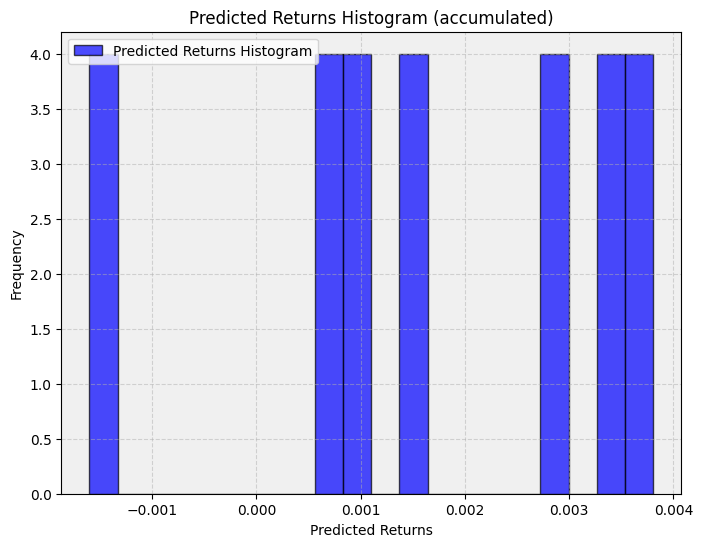

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os

# Function to visualize the frequency histogram of predicted returns
def visualize_histogram(predicted_returns):
    plt.figure(figsize=(8, 6))

    # Calculate and plot the frequency histogram of predicted returns
    hist, bins, _ = plt.hist(
        predicted_returns, 
        bins=20, 
        alpha=0.7, 
        color='blue', 
        edgecolor='black',  # Add black outline
        label='Predicted Returns Histogram'
    )
    
    # Customize plot appearance
    plt.xlabel('Predicted Returns')
    plt.ylabel('Frequency')
    plt.title('Predicted Returns Histogram (accumulated)')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)  # Add gridlines
    
    # Set a darker background color
    ax = plt.gca()
    ax.set_facecolor('#F0F0F0')  # Light gray background
    
    # Show the histogram
    plt.show()


# Function to save and load accumulated predicted returns
def save_accumulated_returns(filename, predicted_returns):
    with open(filename, 'a') as file:
        np.savetxt(file, predicted_returns, delimiter=',')

def load_accumulated_returns(filename):
    try:
        return np.genfromtxt(filename, delimiter=',').tolist()
    except FileNotFoundError:
        return []

# Function to clear accumulated predicted returns
def clear_accumulated_returns(filename):
    choice = input("Do you want to clear the accumulated data? (y/n): ").strip().lower()
    if choice == 'y':
        with open(filename, 'w') as file:
            file.write('')
        print("Data cleared.")
        return True
    elif choice == 'n':
        print("Data not cleared.")
        return False
    else:
        print("Invalid choice. Please choose 'y' to clear or 'n' to cancel.")
        return False

# Main Function
if __name__ == "__main__":
    # Example: Generate some sample predicted returns data (replace with your data)
    predicted_returns_example = predicted_returns

    # Specify the filename for storing accumulated predicted returns
    filename = 'predicted_returns.csv'

    # Check if the file exists and if you want to clear the data
    if not predicted_returns_example:
        print("No predicted returns data to accumulate.")
    else:
        if not os.path.exists(filename):
            print("No existing data file found.")
        else:
            clear_choice = clear_accumulated_returns(filename)
            if clear_choice or not clear_choice:  # Check if data is cleared or 'n' is chosen
                # Load previously accumulated predicted returns
                predicted_returns_accumulated = load_accumulated_returns(filename)

                # Accumulate the predicted returns for later analysis
                predicted_returns_accumulated.extend(predicted_returns_example)

                # Save the accumulated predicted returns
                save_accumulated_returns(filename, predicted_returns_accumulated)

                # Visualize the histogram of accumulated predicted returns
                visualize_histogram(predicted_returns_accumulated)


-----------------------------------------------------
------------------------------------------------------

**# Backup**

Whole code at once

[*********************100%***********************]  1 of 1 completed
Best Model: RandomForestRegressor()
Best MSE: 8.915000212088261e-05
Best R-squared: -0.1877130255411974
        Date  Predicted_Return
0 2023-08-01          0.004933
1 2023-08-02          0.001315
2 2023-08-03          0.000486
3 2023-08-04          0.000370
4 2023-08-07          0.004921
5 2023-08-08          0.003239
6 2023-08-09          0.002216


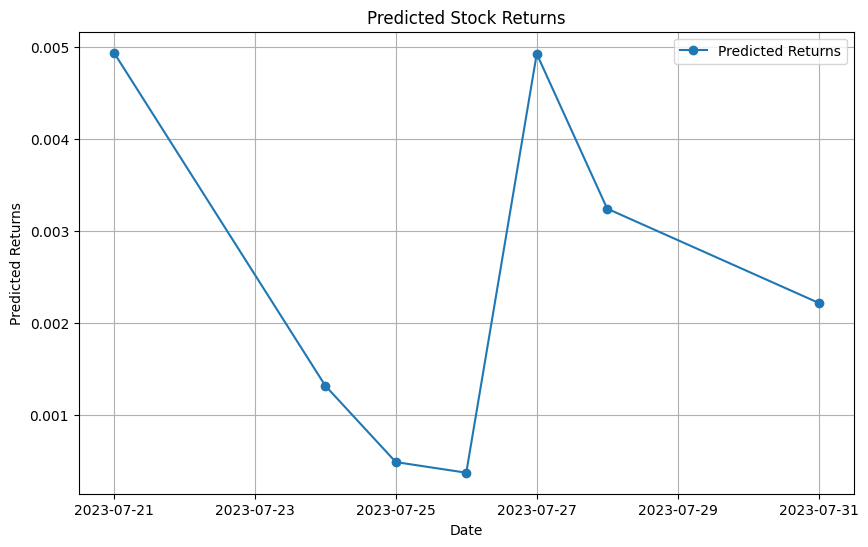

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Function to fetch stock data
def fetch_stock_data(stock_symbol, start_date, end_date):
    stock_data = yf.download(stock_symbol, start=start_date, end=end_date)
    return stock_data.dropna()

# Function to calculate daily returns
def calculate_daily_returns(stock_data):
    stock_data['Daily_Return'] = stock_data['Adj Close'].pct_change()
    stock_data = stock_data.dropna()  # Remove rows with NaN values
    return stock_data.dropna()
# Function to calculate Simple Moving Average (SMA) and Exponential Moving Average (EMA)
def calculate_sma_ema(stock_data, window):
    stock_data['SMA'] = stock_data['Close'].rolling(window=window).mean()
    stock_data['EMA'] = stock_data['Close'].ewm(span=window, adjust=False).mean()
    return stock_data.dropna()

# Function to prepare the data
def prepare_data(stock_data, num_days):
    X = []
    y = []
    
    for i in range(len(stock_data) - num_days):
        X.append(stock_data[['Daily_Return', 'SMA', 'EMA']].iloc[i:i+num_days].values.flatten())
        y.append(stock_data['Daily_Return'].iloc[i+num_days])
           
    return np.array(X), np.array(y)

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import r2_score

# Function to train and evaluate machine learning models
def train_and_evaluate_models(X_train, y_train, X_test, y_test):
    models = {
        'Linear Regression': LinearRegression(),
        'Random Forest': RandomForestRegressor(),
    }
    
    best_model = None
    best_mse = float('inf')
    best_r_squared = -float('inf')
    
    for name, model in models.items():
        if name == 'ARIMA':
            # ARIMA initialization and fitting
            arima_model = ARIMA(y_train, order=(5, 1, 0))
            model_fit = arima_model.fit()
            y_pred = model_fit.forecast(steps=len(X_test))
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            
        mse = mean_squared_error(y_test, y_pred)
        r_squared = r2_score(y_test, y_pred)
        
        if mse < best_mse:
            best_mse = mse
            best_r_squared = r_squared
            best_model = model
        elif mse == best_mse and r_squared > best_r_squared:
            # Only consider R-squared if MSE is the same
            best_r_squared = r_squared
            best_model = model
    print(f"Best Model: {best_model}") 
    print(f"Best MSE: {best_mse}")
    print(f"Best R-squared: {best_r_squared}")
    
    return best_model



# Function to visualize predictions
def visualize_predictions(predicted_returns, date_labels):
    plt.figure(figsize=(10, 6))
    plt.plot(date_labels, predicted_returns, label='Predicted Returns', marker='o')
    plt.xlabel('Date')
    plt.ylabel('Predicted Returns')
    plt.title('Predicted Stock Returns')
    plt.legend()
    plt.grid(True)
    plt.show()

# Main Function
if __name__ == "__main__":
    stock_symbol = "AAPL"  # Replace with the stock symbol you're interested in
    start_date = "2023-01-01"
    end_date = "2023-08-01"
    num_days = 7  # Specify how many days in advance you want to predict
    stock_data = fetch_stock_data(stock_symbol, start_date, end_date)
    daily_returns_data = calculate_daily_returns(stock_data)
    
    # Choose the window size for SMA and EMA
    window = 20  # You can adjust this as needed
    
    stock_data = calculate_sma_ema(daily_returns_data, window)
    
    X, y = prepare_data(stock_data, num_days)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    
    best_model = train_and_evaluate_models(X_train, y_train, X_test, y_test)
    
    # Predict num_days in advance using the best model
    last_week_data = X_test[-1].reshape(1, -1)  # Take the last row of data
    
    predicted_returns = []
    
    for i in range(num_days):
        # Predict one day ahead
        prediction = best_model.predict(last_week_data)  # Predict one day
        predicted_returns.append(prediction[0])  # Append the prediction to the list
         # Update the last_week_data for the next prediction
        new_data_point = np.array([prediction[0], stock_data['SMA'].iloc[-num_days+i+1], stock_data['EMA'].iloc[-num_days+i+1]])
        last_week_data = np.roll(last_week_data, -3)  # Roll the array to remove the oldest day's data
        last_week_data[0, -3:] = new_data_point  # Append the new prediction data
    
    # Create a range of dates for the upcoming week
    prediction_dates = pd.date_range(start=end_date, periods=num_days, freq='B')
    date_labels = stock_data.index[-num_days:]
    
    # Create a DataFrame with dates and corresponding predicted returns
    prediction_df = pd.DataFrame({'Date': prediction_dates, 'Predicted_Return': predicted_returns})

    print(prediction_df)

    visualize_predictions(predicted_returns, date_labels)


Další backup

[*********************100%***********************]  1 of 1 completed
Best Model: Linear Regression
Best Model: Random Forest
Best MSE: 0.00012042027482383947


<Figure size 1200x600 with 0 Axes>

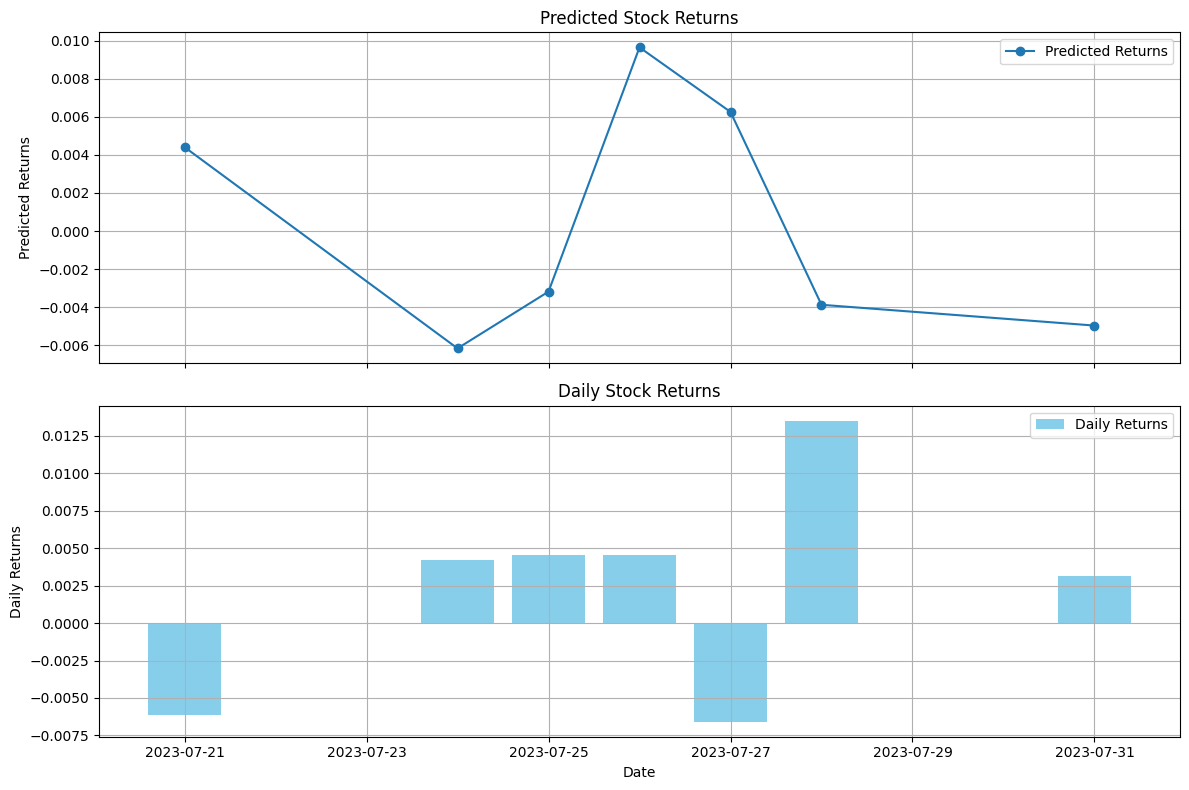

[*********************100%***********************]  1 of 1 completed

1 Failed download:
- FB: No timezone found, symbol may be delisted
Not enough data for stock symbol FB. Skipping.
[*********************100%***********************]  1 of 1 completed
Best Model: Linear Regression
Best Model: Random Forest
Best MSE: 0.00013135284536428253


<Figure size 1200x600 with 0 Axes>

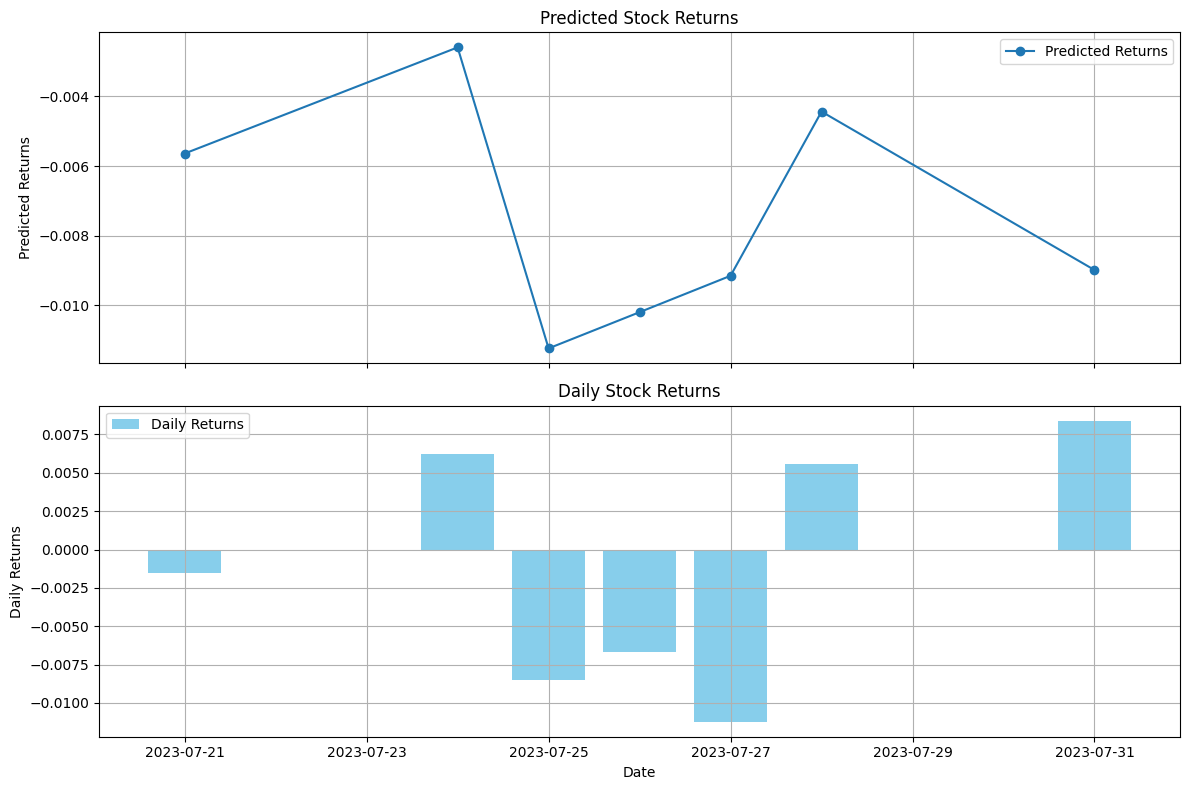

In [16]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Function to fetch stock data
def fetch_stock_data(stock_symbol, start_date, end_date):
    stock_data = yf.download(stock_symbol, start=start_date, end=end_date)
    return stock_data.dropna()

# Function to calculate daily returns
def calculate_daily_returns(stock_data):
    stock_data['Daily_Return'] = stock_data['Adj Close'].pct_change()
    stock_data = stock_data.dropna()  # Remove rows with NaN values
    return stock_data.dropna()

# Function to calculate Simple Moving Average (SMA) and Exponential Moving Average (EMA)
def calculate_sma_ema(stock_data, window):
    stock_data['SMA'] = stock_data['Close'].rolling(window=window).mean()
    stock_data['EMA'] = stock_data['Close'].ewm(span=window, adjust=False).mean()
    return stock_data.dropna()

# Function to prepare the data
def prepare_data(stock_data, num_days):
    X = []
    y = []
    
    for i in range(len(stock_data) - num_days):
        X.append(stock_data[['Daily_Return', 'SMA', 'EMA']].iloc[i:i+num_days].values.flatten())
        y.append(stock_data['Daily_Return'].iloc[i+num_days])
           
    return np.array(X), np.array(y)

# Function to train and evaluate machine learning models
def train_and_evaluate_models(X_train, y_train, X_test, y_test):
    models = {
        'Linear Regression': LinearRegression(),
        'Random Forest': RandomForestRegressor(),
    }
    
    best_model = None
    best_mse = float('inf')
    
    for name, model in models.items():
        if name == 'ARIMA':
            # ARIMA initialization and fitting
            model = ARIMA(y_train, order=(5, 1, 0))
            model_fit = model.fit()
            y_pred = model_fit.forecast(steps=len(X_test))
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            
        mse = mean_squared_error(y_test, y_pred)
        
        if mse < best_mse:
            best_mse = mse
            best_model = model
            print(f"Best Model: {name}")
    
    print(f"Best MSE: {best_mse}")
    
    return best_model

# Function to visualize predictions and daily returns
def visualize_predictions(predicted_returns, date_labels, daily_returns):
    plt.figure(figsize=(12, 6))

    # Create subplots with shared x-axis
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

    # Plot the line chart for predicted returns
    ax1.plot(date_labels, predicted_returns, label='Predicted Returns', marker='o')
    ax1.set_ylabel('Predicted Returns')
    ax1.set_title('Predicted Stock Returns')
    ax1.legend()
    ax1.grid(True)

    # Plot the bar chart for daily returns
    ax2.bar(date_labels, daily_returns, label='Daily Returns', color='skyblue')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Daily Returns')
    ax2.set_title('Daily Stock Returns')
    ax2.legend()
    ax2.grid(True)

    # Adjust layout for better visualization
    plt.tight_layout()

    # Show the combined chart
    plt.show()

# Main Function
if __name__ == "__main__":
    # Get user input for up to three stock symbols
    stock_symbols = []
    for i in range(3):
        stock_symbol = input(f"Enter stock symbol {i+1} (or press Enter to stop): ")
        if not stock_symbol:
            break
        stock_symbols.append(stock_symbol)
    
    if not stock_symbols:
        print("No stock symbols provided. Exiting.")
        exit()

    # Specify the start date and number of days to forecast
    start_date = input("Enter the start date (YYYY-MM-DD): ")
    num_days = input("Enter the number of days to forecast (1-60): ")

    # Validate the number of days
    try:
        num_days = int(num_days)
        if not (1 <= num_days <= 60):
            print("Invalid number of days. Please enter a value between 1 and 60.")
            exit()
    except ValueError:
        print("Invalid number of days. Please enter a valid number.")
        exit()

    end_date = "2023-08-01"  # You can set the end date as needed

    # Fetch data, train models, and visualize predictions for each stock
    for stock_symbol in stock_symbols:
        stock_data = fetch_stock_data(stock_symbol, start_date, end_date)
        
        # Check if there is enough data for training and testing
        if len(stock_data) <= num_days:
            print(f"Not enough data for stock symbol {stock_symbol}. Skipping.")
            continue
        
        daily_returns_data = calculate_daily_returns(stock_data)
        
        # Choose the window size for SMA and EMA
        window = 20  # You can adjust this as needed
        
        stock_data = calculate_sma_ema(daily_returns_data, window)
        
        X, y = prepare_data(stock_data, num_days)
        
        # Check if there is enough data for training and testing
        if len(X) <= num_days:
            print(f"Not enough data for stock symbol {stock_symbol}. Skipping.")
            continue
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
        
        # Check if there is enough data for training and testing
        if len(X_train) == 0 or len(X_test) == 0:
            print(f"Not enough data for stock symbol {stock_symbol}. Skipping.")
            continue
        
        best_model = train_and_evaluate_models(X_train, y_train, X_test, y_test)
        
        # Predict num_days in advance using the best model
        last_week_data = X_test[-1].reshape(1, -1)  # Take the last row of data
        
        predicted_returns = []
        
        for i in range(num_days):
            # Predict one day ahead
            prediction = best_model.predict(last_week_data)  # Predict one day
            predicted_returns.append(prediction[0])  # Append the prediction to the list
             # Update the last_week_data for the next prediction
            new_data_point = np.array([prediction[0], stock_data['SMA'].iloc[-num_days+i+1], stock_data['EMA'].iloc[-num_days+i+1]])
            last_week_data = np.roll(last_week_data, -3)  # Roll the array to remove the oldest day's data
            last_week_data[0, -3:] = new_data_point  # Append the new prediction data
        
        # Create a range of dates for the upcoming week
        prediction_dates = pd.date_range(start=end_date, periods=num_days, freq='B')
        date_labels = stock_data.index[-num_days:]
        
        # Create a DataFrame with dates and corresponding predicted returns
        prediction_df = pd.DataFrame({'Date': prediction_dates, 'Predicted_Return': predicted_returns})

        visualize_predictions(predicted_returns, date_labels, daily_returns_data['Daily_Return'][-num_days:])


FINAL CODE
- problemky
    - neda se zmenit datum
    - neco jineho nez tyden nefunguje
    - foolproof stocks ktere nejsou v dictionary
    - neda se odhadovat pro data dopredu


    - Trochu si pohrát s interfacem
        - možnost více než 3 stocks?
        - drop-down menu by bylo top
        - napsat pár error kódů co se posralo
        - double check funkce a názvy, aby to nebylo defaultní a nevypadalo to blbě

[*********************100%***********************]  1 of 1 completed
Best Model: Linear Regression
Best MSE: 0.00020120752735582965
[*********************100%***********************]  1 of 1 completed
Best Model: Linear Regression
Best Model: Random Forest
Best MSE: 0.0011315540118199171
[*********************100%***********************]  1 of 1 completed
Best Model: Linear Regression
Best MSE: 8.825655816648462e-05


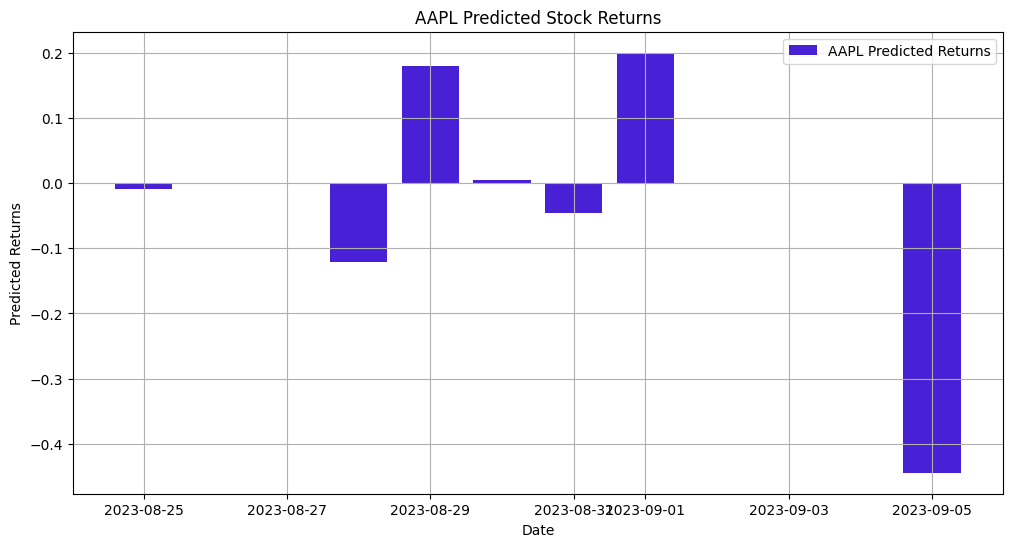

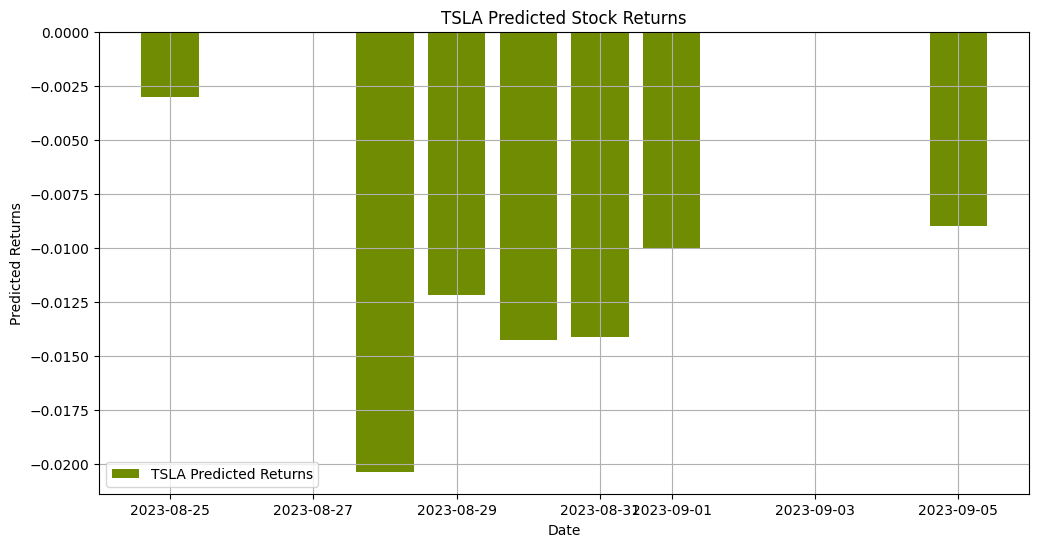

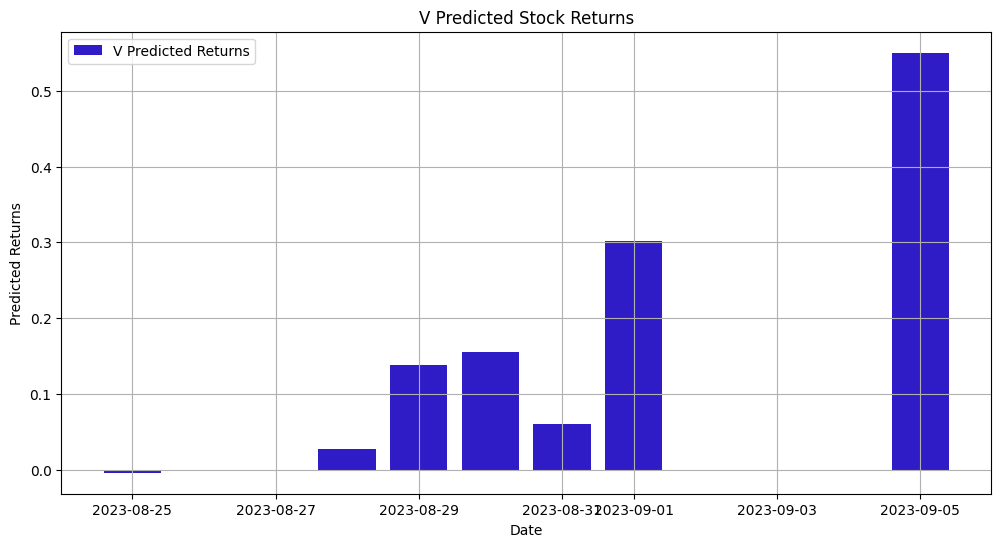

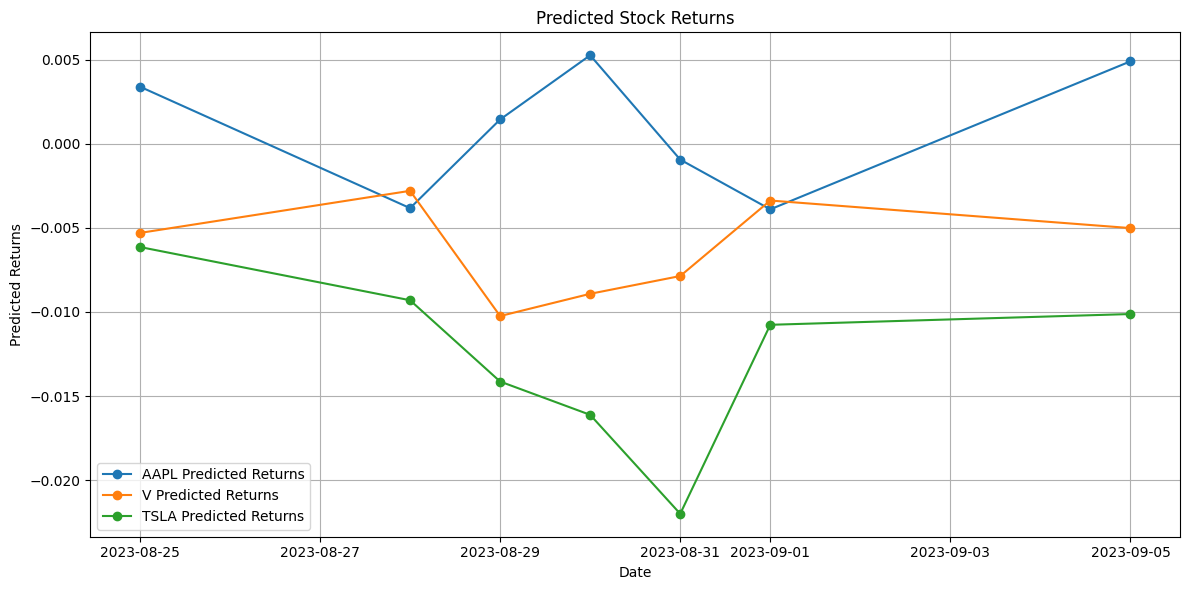

In [9]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Function to fetch stock data
def fetch_stock_data(stock_symbol, start_date, end_date):
    stock_data = yf.download(stock_symbol, start=start_date, end=end_date)
    return stock_data.dropna()

# Function to calculate daily returns
def calculate_daily_returns(stock_data):
    stock_data['Daily_Return'] = stock_data['Adj Close'].pct_change()
    stock_data = stock_data.dropna()  # Remove rows with NaN values
    return stock_data.dropna()

# Function to calculate Simple Moving Average (SMA) and Exponential Moving Average (EMA)
def calculate_sma_ema(stock_data, window):
    stock_data['SMA'] = stock_data['Close'].rolling(window=window).mean()
    stock_data['EMA'] = stock_data['Close'].ewm(span=window, adjust=False).mean()
    return stock_data.dropna()

# Function to prepare the data
def prepare_data(stock_data, num_days):
    X = []
    y = []
    
    for i in range(len(stock_data) - num_days):
        X.append(stock_data[['Daily_Return', 'SMA', 'EMA']].iloc[i:i+num_days].values.flatten())
        y.append(stock_data['Daily_Return'].iloc[i+num_days])
           
    return np.array(X), np.array(y)

# Function to train and evaluate machine learning models
def train_and_evaluate_models(X_train, y_train, X_test, y_test):
    models = {
        'Linear Regression': LinearRegression(),
        'Random Forest': RandomForestRegressor(),
    }
    
    best_model = None
    best_mse = float('inf')
    
    for name, model in models.items():
        if name == 'ARIMA':
            # ARIMA initialization and fitting
            model = ARIMA(y_train, order=(5, 1, 0))
            model_fit = model.fit()
            y_pred = model_fit.forecast(steps=len(X_test))
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            
        mse = mean_squared_error(y_test, y_pred)
        
        if mse < best_mse:
            best_mse = mse
            best_model = model
            print(f"Best Model: {name}")
    
    print(f"Best MSE: {best_mse}")
    
    return best_model

# Function to visualize predictions and daily returns
def visualize_predictions(predicted_returns, date_labels, daily_returns, stock_symbol):
    plt.figure(figsize=(12, 6))

    # Create a bar chart for predicted returns
    plt.bar(date_labels, predicted_returns, label=f'{stock_symbol} Predicted Returns', color=np.random.rand(3,))
    plt.title(f'{stock_symbol} Predicted Stock Returns')
    plt.xlabel('Date')
    plt.ylabel('Predicted Returns')
    plt.legend()
    plt.grid(True)

# Main Function
if __name__ == "__main__":
    # Get user input for up to three stock symbols
    stock_symbols = []
    for i in range(3):
        stock_symbol = input(f"Enter stock symbol {i+1} (or press Enter to stop): ")
        if not stock_symbol:
            break
        stock_symbols.append(stock_symbol)
    
    if not stock_symbols:
        print("No stock symbols provided. Exiting.")
        exit()

    # Specify the start date and number of days to forecast
    start_date = input("Enter the start date (YYYY-MM-DD): ")
    num_days = input("Enter the number of days to forecast (1-60): ")

    # Validate the number of days
    try:
        num_days = int(num_days)
        if not (1 <= num_days <= 60):
            print("Invalid number of days. Please enter a value between 1 and 60.")
            exit()
    except ValueError:
        print("Invalid number of days. Please enter a valid number.")
        exit()

    end_date = "2023-10-01"  # You can set the end date as needed
    
    # Fetch data, train models, and visualize predictions for each stock
    for stock_symbol in stock_symbols:
        stock_data = fetch_stock_data(stock_symbol, start_date, end_date)
        
        # Check if there is enough data for training and testing
        if len(stock_data) <= num_days:
            print(f"Not enough data for stock symbol {stock_symbol}. Skipping.")
            continue
        
        daily_returns_data = calculate_daily_returns(stock_data)
        
        # Choose the window size for SMA and EMA
        window = 20  # You can adjust this as needed
        
        stock_data = calculate_sma_ema(daily_returns_data, window)
        
        X, y = prepare_data(stock_data, num_days)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
        
        best_model = train_and_evaluate_models(X_train, y_train, X_test, y_test)
        
        # Predict num_days in advance using the best model
        last_week_data = X_test[-1].reshape(1, -1)  # Take the last row of data
        
        predicted_returns = []
        
        for i in range(num_days):
            # Predict one day ahead
            prediction = best_model.predict(last_week_data)  # Predict one day
            predicted_returns.append(prediction[0])  # Append the prediction to the list
             # Update the last_week_data for the next prediction
            new_data_point = np.array([prediction[0], stock_data['SMA'].iloc[-num_days+i+1], stock_data['EMA'].iloc[-num_days+i+1]])
            last_week_data = np.roll(last_week_data, -3)  # Roll the array to remove the oldest day's data
            last_week_data[0, -3:] = new_data_point  # Append the new prediction data
        
        # Create a range of dates for the upcoming week
        prediction_dates = pd.date_range(start=end_date, periods=num_days, freq='B')
        date_labels = stock_data.index[-num_days:]
        
        # Visualize predictions for each stock
        visualize_predictions(predicted_returns, date_labels, daily_returns_data['Daily_Return'][-num_days:], stock_symbol)
    # Create a single line chart for predicted returns of all stocks
    plt.figure(figsize=(12, 6))
    
    for stock_symbol, predicted_returns in predicted_returns_dict.items():
        plt.plot(date_labels, predicted_returns, label=f'{stock_symbol} Predicted Returns', marker='o')

    plt.title('Predicted Stock Returns')
    plt.xlabel('Date')
    plt.ylabel('Predicted Returns')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


----------------------------------------------------------------

Updated code

[*********************100%***********************]  1 of 1 completed
Best Model: Linear Regression
Best Model: Random Forest
Best MSE: 0.00011147643114775987
[*********************100%***********************]  1 of 1 completed
Best Model: Linear Regression
Best Model: Random Forest
Best MSE: 0.00012723551674104745
[*********************100%***********************]  1 of 1 completed
Best Model: Linear Regression
Best Model: Random Forest
Best MSE: 0.0013126509708590074


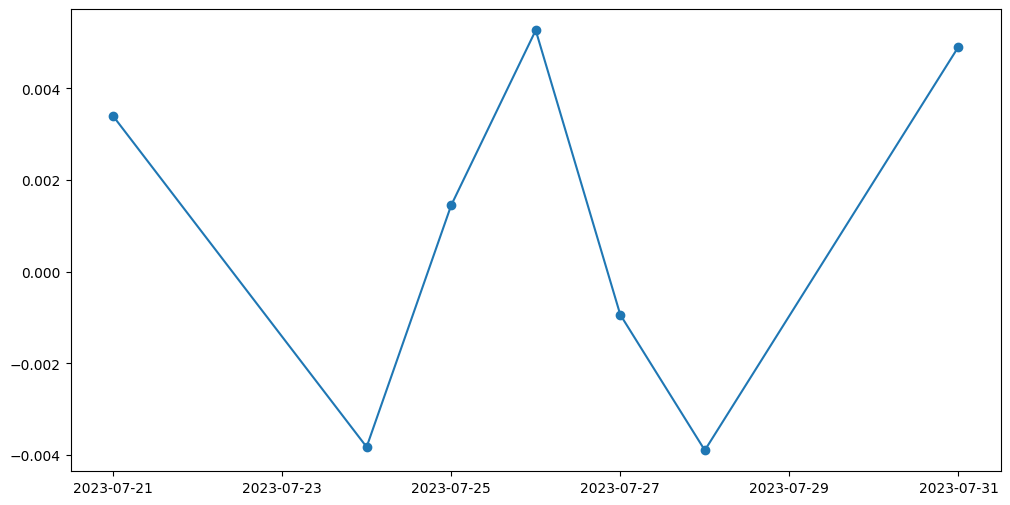

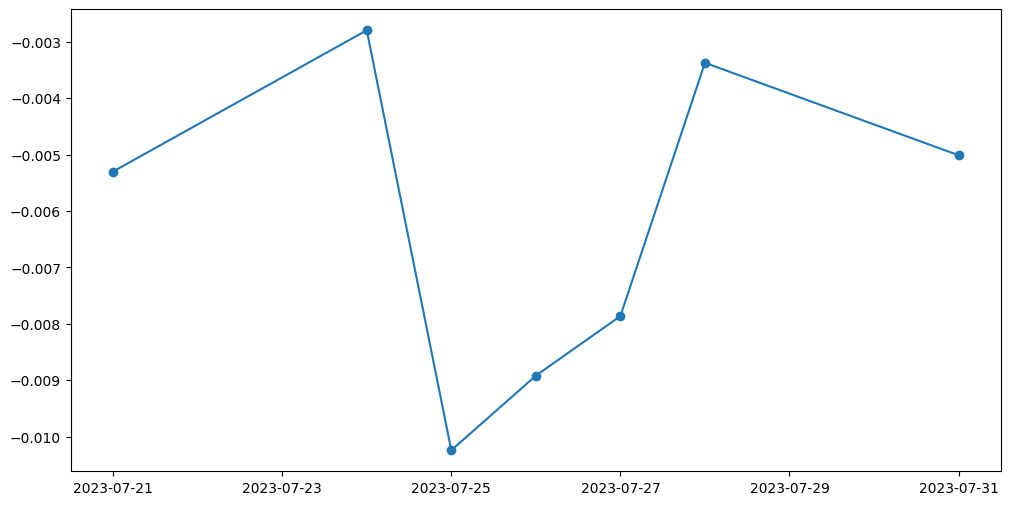

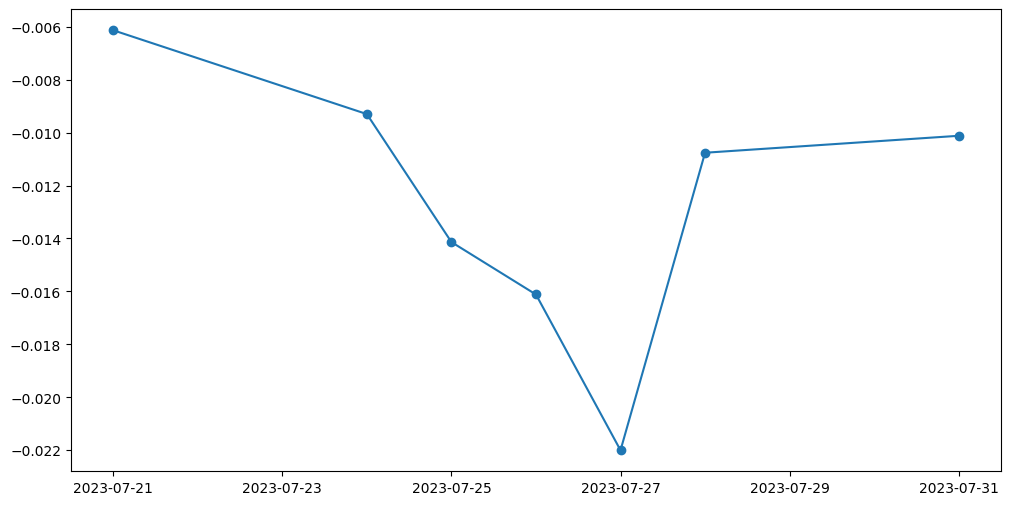

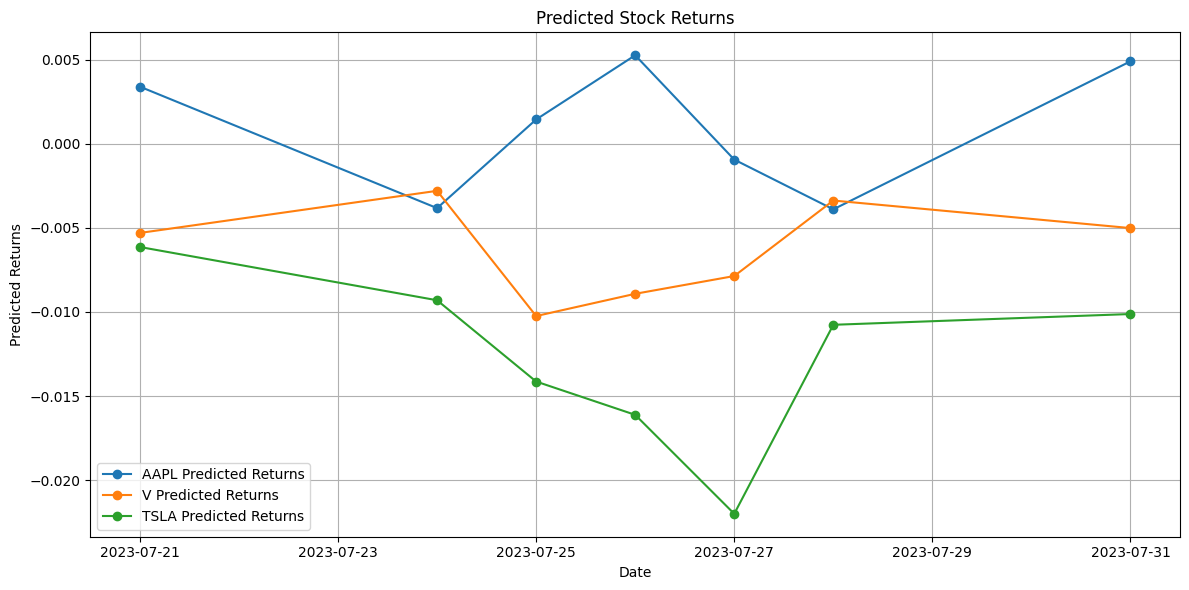

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Function to fetch stock data
def fetch_stock_data(stock_symbol, start_date, end_date):
    stock_data = yf.download(stock_symbol, start=start_date, end=end_date)
    return stock_data.dropna()

# Function to calculate daily returns
def calculate_daily_returns(stock_data):
    stock_data['Daily_Return'] = stock_data['Adj Close'].pct_change()
    stock_data = stock_data.dropna()  # Remove rows with NaN values
    return stock_data.dropna()

# Function to calculate Simple Moving Average (SMA) and Exponential Moving Average (EMA)
def calculate_sma_ema(stock_data, window):
    stock_data['SMA'] = stock_data['Close'].rolling(window=window).mean()
    stock_data['EMA'] = stock_data['Close'].ewm(span=window, adjust=False).mean()
    return stock_data.dropna()

# Function to prepare the data
def prepare_data(stock_data, num_days):
    X = []
    y = []
    
    for i in range(len(stock_data) - num_days):
        X.append(stock_data[['Daily_Return', 'SMA', 'EMA']].iloc[i:i+num_days].values.flatten())
        y.append(stock_data['Daily_Return'].iloc[i+num_days])
           
    return np.array(X), np.array(y)

# Function to train and evaluate machine learning models
def train_and_evaluate_models(X_train, y_train, X_test, y_test):
    models = {
        'Linear Regression': LinearRegression(),
        'Random Forest': RandomForestRegressor(),
    }
    
    best_model = None
    best_mse = float('inf')
    
    for name, model in models.items():
        if name == 'ARIMA':
            # ARIMA initialization and fitting
            model = ARIMA(y_train, order=(5, 1, 0))
            model_fit = model.fit()
            y_pred = model_fit.forecast(steps=len(X_test))
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            
        mse = mean_squared_error(y_test, y_pred)
        
        if mse < best_mse:
            best_mse = mse
            best_model = model
            print(f"Best Model: {name}")
    
    print(f"Best MSE: {best_mse}")
    
    return best_model

# Function to visualize predictions and daily returns
def visualize_predictions(predicted_returns, date_labels, daily_returns, stock_symbol):
    plt.figure(figsize=(12, 6))

    # Plot the line chart for predicted returns
    plt.plot(date_labels, predicted_returns, label=f'{stock_symbol} Predicted Returns', marker='o')

# Main Function
if __name__ == "__main__":
    # Get user input for up to three stock symbols
    stock_symbols = []
    for i in range(3):
        stock_symbol = input(f"Enter stock symbol {i+1} (or press Enter to stop): ")
        if not stock_symbol:
            break
        stock_symbols.append(stock_symbol)
    
    if not stock_symbols:
        print("No stock symbols provided. Exiting.")
        exit()

    # Specify the start date and number of days to forecast
    start_date = input("Enter the start date (YYYY-MM-DD): ")
    num_days = input("Enter the number of days to forecast (1-60): ")

    # Validate the number of days
    try:
        num_days = int(num_days)
        if not (1 <= num_days <= 60):
            print("Invalid number of days. Please enter a value between 1 and 60.")
            exit()
    except ValueError:
        print("Invalid number of days. Please enter a valid number.")
        exit()

    end_date = "2023-08-01"  # You can set the end date as needed

    # Create a dictionary to store predicted returns for each stock
    predicted_returns_dict = {}
    
    # Fetch data, train models, and visualize predictions for each stock
    for stock_symbol in stock_symbols:
        stock_data = fetch_stock_data(stock_symbol, start_date, end_date)
        
        # Check if there is enough data for training and testing
        if len(stock_data) <= num_days:
            print(f"Not enough data for stock symbol {stock_symbol}. Skipping.")
            continue
        
        daily_returns_data = calculate_daily_returns(stock_data)
        
        # Choose the window size for SMA and EMA
        window = 20  # You can adjust this as needed
        
        stock_data = calculate_sma_ema(daily_returns_data, window)
        
        X, y = prepare_data(stock_data, num_days)
        
        # Check if there is enough data for training and testing
        if len(X) <= num_days:
            print(f"Not enough data for stock symbol {stock_symbol}. Skipping.")
            continue
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
        
        # Check if there is enough data for training and testing
        if len(X_train) == 0 or len(X_test) == 0:
            print(f"Not enough data for stock symbol {stock_symbol}. Skipping.")
            continue
        
        best_model = train_and_evaluate_models(X_train, y_train, X_test, y_test)
        
        # Predict num_days in advance using the best model
        last_week_data = X_test[-1].reshape(1, -1)  # Take the last row of data
        
        predicted_returns = []
        
        for i in range(num_days):
            # Predict one day ahead
            prediction = best_model.predict(last_week_data)  # Predict one day
            predicted_returns.append(prediction[0])  # Append the prediction to the list
             # Update the last_week_data for the next prediction
            new_data_point = np.array([prediction[0], stock_data['SMA'].iloc[-num_days+i+1], stock_data['EMA'].iloc[-num_days+i+1]])
            last_week_data = np.roll(last_week_data, -3)  # Roll the array to remove the oldest day's data
            last_week_data[0, -3:] = new_data_point  # Append the new prediction data
        
        # Create a range of dates for the upcoming week
        prediction_dates = pd.date_range(start=end_date, periods=num_days, freq='B')
        date_labels = stock_data.index[-num_days:]
        
        # Store predicted returns in the dictionary
        predicted_returns_dict[stock_symbol] = predicted_returns
        
        # Visualize predictions for each stock
        visualize_predictions(predicted_returns, date_labels, daily_returns_data['Daily_Return'][-num_days:], stock_symbol)

    # Create a single line chart for predicted returns of all stocks
    plt.figure(figsize=(12, 6))
    
    for stock_symbol, predicted_returns in predicted_returns_dict.items():
        plt.plot(date_labels, predicted_returns, label=f'{stock_symbol} Predicted Returns', marker='o')

    plt.title('Predicted Stock Returns')
    plt.xlabel('Date')
    plt.ylabel('Predicted Returns')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


[*********************100%***********************]  1 of 1 completed
Best Model: Linear Regression
Best Model: Random Forest
Best MSE: 8.506809522905764e-05


<Figure size 1200x600 with 0 Axes>

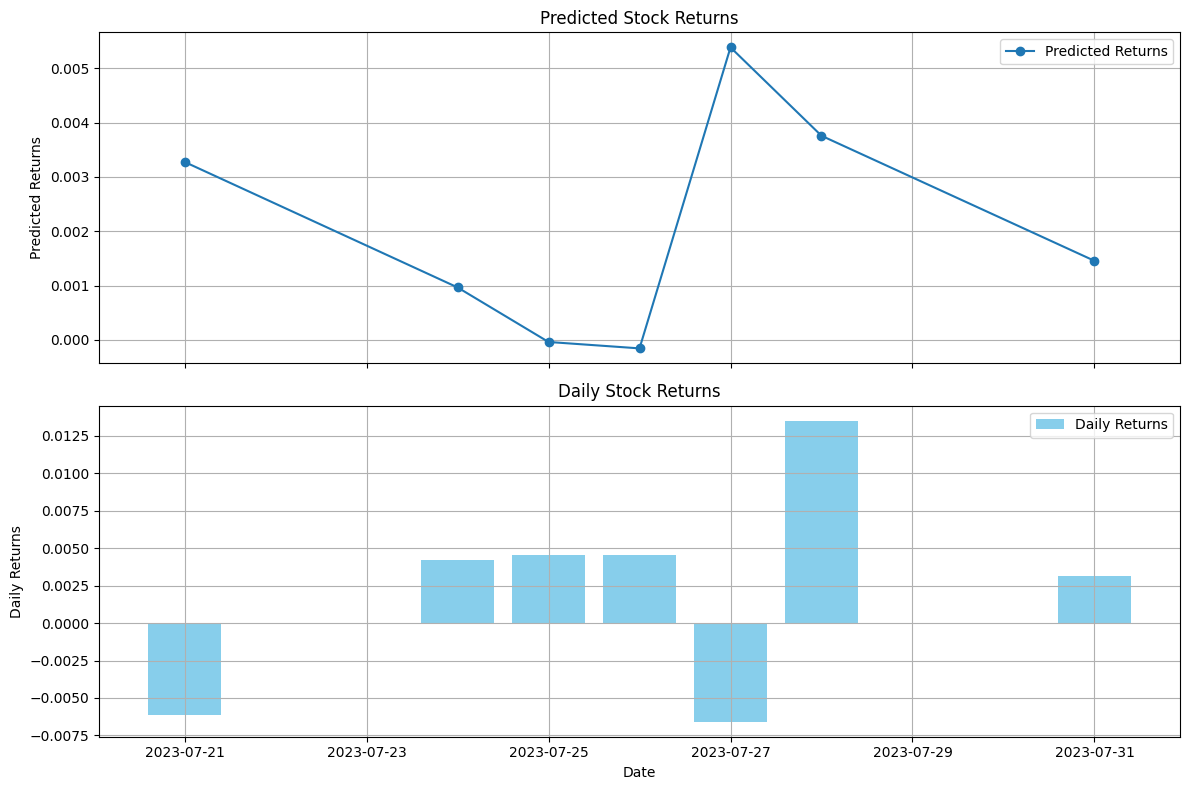

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Function to fetch stock data
def fetch_stock_data(stock_symbol, start_date, end_date):
    stock_data = yf.download(stock_symbol, start=start_date, end=end_date)
    return stock_data.dropna()

# Function to calculate daily returns
def calculate_daily_returns(stock_data):
    stock_data['Daily_Return'] = stock_data['Adj Close'].pct_change()
    stock_data = stock_data.dropna()  # Remove rows with NaN values
    return stock_data.dropna()

# Function to calculate Simple Moving Average (SMA) and Exponential Moving Average (EMA)
def calculate_sma_ema(stock_data, window):
    stock_data['SMA'] = stock_data['Close'].rolling(window=window).mean()
    stock_data['EMA'] = stock_data['Close'].ewm(span=window, adjust=False).mean()
    return stock_data.dropna()

# Function to prepare the data
def prepare_data(stock_data, num_days):
    X = []
    y = []
    
    for i in range(len(stock_data) - num_days):
        X.append(stock_data[['Daily_Return', 'SMA', 'EMA']].iloc[i:i+num_days].values.flatten())
        y.append(stock_data['Daily_Return'].iloc[i+num_days])
           
    return np.array(X), np.array(y)

# Function to train and evaluate machine learning models
def train_and_evaluate_models(X_train, y_train, X_test, y_test):
    models = {
        'Linear Regression': LinearRegression(),
        'Random Forest': RandomForestRegressor(),
    }
    
    best_model = None
    best_mse = float('inf')
    
    for name, model in models.items():
        if name == 'ARIMA':
            # ARIMA initialization and fitting
            model = ARIMA(y_train, order=(5, 1, 0))
            model_fit = model.fit()
            y_pred = model_fit.forecast(steps=len(X_test))
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            
        mse = mean_squared_error(y_test, y_pred)
        
        if mse < best_mse:
            best_mse = mse
            best_model = model
            print(f"Best Model: {name}")
    
    print(f"Best MSE: {best_mse}")
    
    return best_model


# Function to visualize predictions and daily returns
def visualize_predictions(predicted_returns, date_labels, daily_returns):
    plt.figure(figsize=(12, 6))

    # Create subplots with shared x-axis
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

    # Plot the line chart for predicted returns
    ax1.plot(date_labels, predicted_returns, label='Predicted Returns', marker='o')
    ax1.set_ylabel('Predicted Returns')
    ax1.set_title('Predicted Stock Returns')
    ax1.legend()
    ax1.grid(True)

    # Plot the bar chart for daily returns
    ax2.bar(date_labels, daily_returns, label='Daily Returns', color='skyblue')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Daily Returns')
    ax2.set_title('Daily Stock Returns')
    ax2.legend()
    ax2.grid(True)

    # Adjust layout for better visualization
    plt.tight_layout()

    # Show the combined chart
    plt.show()

# Main Function
if __name__ == "__main__":
    stock_symbol = "AAPL"  # Replace with the stock symbol you're interested in
    start_date = "2023-01-01"
    end_date = "2023-08-01"
    num_days = 7  # Specify how many days in advance you want to predict
    stock_data = fetch_stock_data(stock_symbol, start_date, end_date)
    daily_returns_data = calculate_daily_returns(stock_data)
    
    # Choose the window size for SMA and EMA
    window = 20  # You can adjust this as needed
    
    stock_data = calculate_sma_ema(daily_returns_data, window)
    
    X, y = prepare_data(stock_data, num_days)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    
    best_model = train_and_evaluate_models(X_train, y_train, X_test, y_test)
    
    # Predict num_days in advance using the best model
    last_week_data = X_test[-1].reshape(1, -1)  # Take the last row of data
    
    predicted_returns = []
    
    for i in range(num_days):
        # Predict one day ahead
        prediction = best_model.predict(last_week_data)  # Predict one day
        predicted_returns.append(prediction[0])  # Append the prediction to the list
         # Update the last_week_data for the next prediction
        new_data_point = np.array([prediction[0], stock_data['SMA'].iloc[-num_days+i+1], stock_data['EMA'].iloc[-num_days+i+1]])
        last_week_data = np.roll(last_week_data, -3)  # Roll the array to remove the oldest day's data
        last_week_data[0, -3:] = new_data_point  # Append the new prediction data
    
    # Create a range of dates for the upcoming week
    prediction_dates = pd.date_range(start=end_date, periods=num_days, freq='B')
    date_labels = stock_data.index[-num_days:]
    
    # Create a DataFrame with dates and corresponding predicted returns
    prediction_df = pd.DataFrame({'Date': prediction_dates, 'Predicted_Return': predicted_returns})

    visualize_predictions(predicted_returns, date_labels, daily_returns_data['Daily_Return'][-num_days:])


